In [1]:
import pandas as pd
from pybedtools import BedTool as BT

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
# This saves fonts as fonts in the svg and not as shapes
plt.rcParams['svg.fonttype'] = 'none'

import numpy as np
from scipy.stats import mannwhitneyu as MWU

import warnings
warnings.filterwarnings('ignore')

## Data Load

We assign a BASAL region to each gene, it starts from its TSS and extends 5kb upstream and 1kb downstream, or untill it encounters another TSS.

For the GREAT region, we extend the BASAL region UP TO 1Mb in each way, or until a BASAL region of another gene is encountered.    
     
Here, we load and use the GREAT regions

In [2]:
greg = {}

greg['Dre'] = pd.read_csv("./data/genomic_regions/GREAT_dre.bed", sep='\t', header=None)
greg['Dre'].columns = ['chrom','start','end','geneID','score','strand']
greg['Dre']['score'] = greg['Dre']['end'] - greg['Dre']['start']

greg['Bla'] = pd.read_csv("./data/genomic_regions/GREAT_bla.bed", sep='\t', header=None)
greg['Bla'].columns = ['chrom','start','end','geneID','score','strand']
greg['Bla']['score'] = greg['Bla']['end'] - greg['Bla']['start']

greg['Ola'] = pd.read_csv("./data/genomic_regions/GREAT_ola.bed", sep='\t', header=None)
greg['Ola'].columns = ['chrom','start','end','geneID','score','strand']
greg['Ola']['score'] = greg['Ola']['end'] - greg['Ola']['start']

greg['Mmu'] = pd.read_csv("./data/genomic_regions/GREAT_mmu.bed", sep='\t', header=None)
greg['Mmu'].columns = ['chrom','start','end','geneID','score','strand']
greg['Mmu']['score'] = greg['Mmu']['end'] - greg['Mmu']['start']

print( [(k,len(v)) for k,v in greg.items()])

[('Dre', 20053), ('Bla', 20569), ('Ola', 15978), ('Mmu', 18842)]


In [3]:
greg['Mmu'].head()

,chrom,start,end,geneID,score,strand
0,chr1,2670503,4359310,ENSMUSG00000051951,1688807,-
1,chr1,3676503,4495409,ENSMUSG00000025900,818906,-
2,chr1,4365319,4784706,ENSMUSG00000025902,419387,-
3,chr1,4501418,4802819,ENSMUSG00000033845,301401,-
4,chr1,4790715,4852810,ENSMUSG00000025903,62095,+


In [4]:
stages = {}
stages['Bla'] = ['8','15','36','60']
stages['Dre'] = ["dome","shield","80epi","8som","24h","48h"]
stages['Ola'] = ["dome","shield","8som","24h","48h"]
stages['Mmu'] = ['DE','ESC']

### The ATAC-seq peaks

As determined by the idr "pipeline", see more in the peak-calling notebook

In [5]:
pre_ = './data/atac_peaks/'

peak_beds = {}

peak_beds['Dre'] = [ (BT("{}zebra_danRer10_{}_idrpeaks.bed".format(pre_,x))
                    .sort()
                    )for x in stages['Dre']]
peak_beds['Bla'] = [(BT("{}amphi_{}_idrpeaks.bed".format(pre_,x))
                     .sort()
                     ) for x in stages['Bla']]
peak_beds['Ola'] = [ (BT("{}medaka_{}_idrpeaks.bed".format(pre_,x))
                    .sort()
                    )for x in stages['Ola']]
peak_beds['Mmu'] = [ (BT("{}mouse_{}_idrpeaks.bed".format(pre_,x))
                    .sort()
                    )for x in stages['Mmu']]


### Grouping of genes into House Keeping, TransDev, Other      

In [11]:
TDG = pd.read_csv("./data/TransDevGenes.tab", sep='\t', header=None)
TDG.columns = ['GFid','species','geneID','newGFid','geneName']
TDG = TDG[TDG['species'].isin(['Bla','Dre','Ola','Mmu'])]
TDgenes = set(TDG.geneID.unique())

In [14]:
HK = pd.read_csv("./data/HouseKeepGenes.tab", sep='\t', header=None)
HK.columns = ['GFid','species','geneID','newGFid','geneName']
HK = HK[HK['species'].isin(['Bla','Dre','Ola','Mmu'])]
HKgenes = set(HK.geneID.unique())

In [16]:
bedfields = ['chrom','start','end','name','score','strand']
big = {}

big['Dre'] = BT().from_dataframe(greg['Dre']).sort()
for bee in peak_beds['Dre']:
    big['Dre'] = big['Dre'].intersect(b = bee, c=True, sorted=True, nonamecheck=True)
big['Dre'] = big['Dre'].to_dataframe()
big['Dre'].columns = bedfields + stages['Dre']

# the other species:
big['Bla'] = BT().from_dataframe(greg['Bla']).sort()
for bee in peak_beds['Bla']:
    big['Bla'] = big['Bla'].intersect(b = bee, c=True, sorted=True, nonamecheck=True)
big['Bla'] = big['Bla'].to_dataframe()
big['Bla'].columns = bedfields + stages['Bla']

big['Ola'] = BT().from_dataframe(greg['Ola']).sort()
for bee in peak_beds['Ola']:
    big['Ola'] = big['Ola'].intersect(b = bee, c=True, sorted=True, nonamecheck=True)
big['Ola'] = big['Ola'].to_dataframe()
big['Ola'].columns = bedfields + stages['Ola']

big['Mmu'] = BT().from_dataframe(greg['Mmu']).sort()
for bee in peak_beds['Mmu']:
    big['Mmu'] = big['Mmu'].intersect(b = bee, c=True, sorted=True, nonamecheck=True)
big['Mmu'] = big['Mmu'].to_dataframe()
big['Mmu'].columns = bedfields + stages['Mmu']

In [17]:
big['Dre'].sample(5)

,chrom,start,end,name,score,strand,dome,shield,80epi,8som,24h,48h
1320,chr10,28701881,29214086,ENSDARG00000026531,512205,-,25,36,58,57,59,101
9753,chr20,43082426,43186666,ENSDARG00000069302,104240,-,10,12,14,10,13,12
11784,chr23,29957588,30034931,ENSDARG00000062129,77343,+,7,8,6,5,9,9
20031,chrUn_KN150653v1,0,55997,ENSDARG00000101012,55997,-,0,0,0,1,1,1
5643,chr16,29457597,29501746,ENSDARG00000040249,44149,-,4,3,2,2,5,6


In [18]:
# set the gene ID as index in all dataframes of 'big'
big_ind = {}
for k,v in big.items():
    big_ind[k] = v.set_index('name')
    big_ind[k].columns = [str(x) for x in big_ind[k].columns]

In [23]:
def categorize(x):
    if x in TDgenes:
        return 'TD'
    elif x in HKgenes:
        return 'HK'
    else:
        return 'Other'

In [24]:

dd_dre = big_ind['Dre'].copy()
dd_dre['category'] = dd_dre.index.to_series().map(categorize)
# dd_dre = dd_dre[dd_dre.category != 'nop']
dd_dre['species'] = 'dre'
dd_dre = dd_dre[stages['Dre']+['category','species']]
dd_dre.columns = stages['Dre']+['category','species']

dd_ola = big_ind['Ola'].copy()
dd_ola['category'] = dd_ola.index.to_series().map(categorize)
# dd_ola = dd_ola[dd_ola.category != 'nop']
dd_ola['species'] = 'ola'
dd_ola = dd_ola[stages['Ola']+['category','species']]
dd_ola.columns = stages['Ola']+['category','species']

dd_bla = big_ind['Bla'].copy()
dd_bla['category'] = dd_bla.index.to_series().map(categorize)
# dd_bla = dd_bla[dd_bla.category != 'nop']
dd_bla['species'] = 'bla'
dd_bla = dd_bla[stages['Bla']+['category','species']]
dd_bla.columns = stages['Bla']+['category','species']

dd_mmu = big_ind['Mmu'].copy()
dd_mmu['category'] = dd_mmu.index.to_series().map(categorize)
# dd_mmu = dd_mmu[dd_mmu.category != 'nop']
dd_mmu['species'] = 'mmu'
dd_mmu = dd_mmu[stages['Mmu']+['category','species']]
dd_mmu.columns = stages['Mmu']+['category','species']

In [25]:
# then melt the DFs from each species and concatenate those
TOPLOT = pd.concat([pd.melt(dd_dre, id_vars=['category','species']),
            pd.melt(dd_bla, id_vars=['category','species']),
            pd.melt(dd_ola, id_vars=['category','species']),
            pd.melt(dd_mmu, id_vars=['category','species'])
            
                   ])
TOPLOT.columns = ['category','species','stage','count']
TOPLOT['specstage'] = TOPLOT.species + '_' + TOPLOT.stage
TOPLOT.head(2)

,category,species,stage,count,specstage
0,Other,dre,dome,0,dre_dome
1,Other,dre,dome,0,dre_dome


In [26]:
# def boxplot_pvals(data, x,x_anq,x_targs,y,hue,hue_order):
#     for targetx in x_targs:
#         for huel in hue_order:
#             m1 = (data[x]==x_anq)
#             mh = data[hue] == huel
#             m2 = (data[x]==targetx)
#             print(targetx, huel, MWU( data.loc[mh & m2, y].values, data.loc[mh & m1, y].values, alternative='greater' ).pvalue)

# def boxplot_pvals_nohue(data, x,x_anq,x_targs,y):
#     for targetx in x_targs:
#             m1 = (data[x]==x_anq)
#             m2 = (data[x]==targetx)
#             print(targetx, MWU( data.loc[m2, y].values, data.loc[ m1, y].values, alternative='greater' ).pvalue)


In [27]:
stagespecorder = ['bla_8','bla_15','bla_36','bla_60',' ',
             'dre_dome','dre_shield','dre_80epi','dre_8som','dre_24h','dre_48h',' ',
             'ola_dome','ola_shield','ola_8som','ola_24h','ola_48h',' ',
             'mmu_ESC','mmu_DE'
            ]

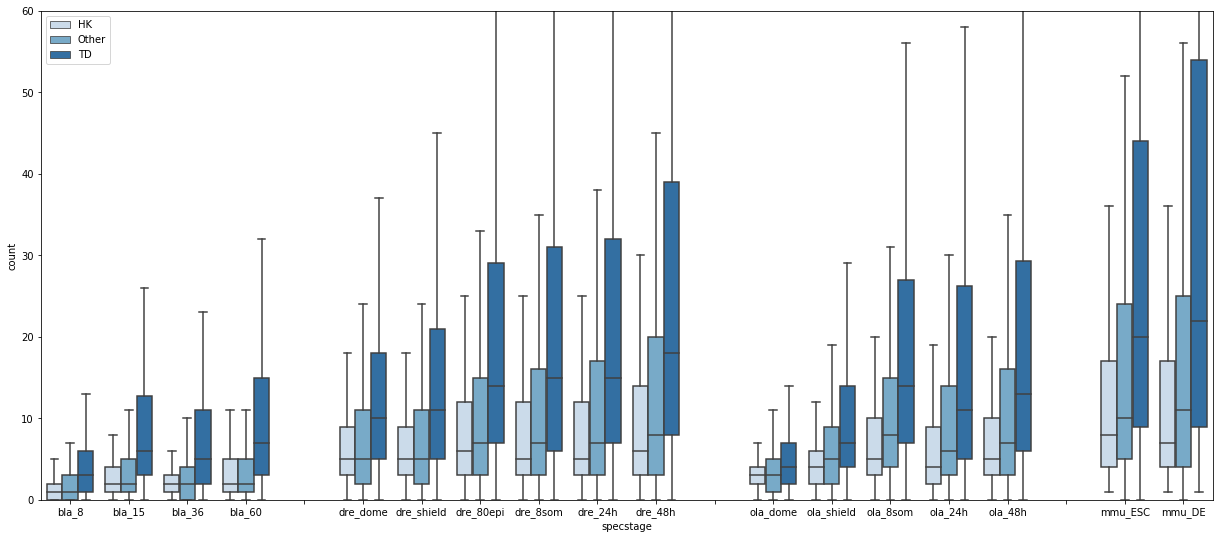

In [29]:
plt.figure(figsize=(21,9))
sns.boxplot(data = TOPLOT, 
            
            x='specstage',
            order=stagespecorder,
            hue='category',
            hue_order = ['HK','Other','TD'],
            y='count',
           fliersize=0, palette='Blues'
            
           )
        
plt.ylim((0,60))
plt.legend(loc='upper left')